In [ ]:
##################################################
# CVsim.m - Cyclic voltammetry simulation
# Peter Attia
# Based on Bard and Faulkner, Appendix B
# EC mechanism
# Updated September 20, 2020
##################################################

import matplotlib.pyplot as plt
import glob
import numpy as np
import os
import random
from IPython.display import clear_output
from numba import njit, prange
import torch
import torch.nn.functional as Func

## INDEPENDENT VARIABLES ##
device = 'cuda'
Concentration = 5e-3;    # [=] mol/L, initial concentration of O. Default = 1.0
D        = .726E-5;   # [=] cm^2/s, O & R diffusion coefficient. Default = 1E-5
etai     = +0.4;    # [=] V, initial overpotential (relative to redox potential). Default = +0.2
etaf     = -0.4;    # [=] V, final overpotential (relative to redox potential). Default = -0.2
v        = .2;      # [=] V/s, sweep rate. Default = 1E-3
n        = 1.0;     # [=] number of electrons transfered. Default = 1
alpha    = 0.51;    # [=] dimensionless charge-transfer coefficient. Default = 0.5
k0       = 1e-2     #np.power(10,-1.3);   # [=] cm/s, electrochemical rate constant. Default = 1E-2
kc       = 1E-3;    # [=] 1/s, chemical rate constant. Default = 1E-3
T        = 298.15;  # [=] K, temperature. Default = 298.15
Sim_Width   = 100   # [=] nm  width of simulation grid
Sim_Height  = 100   # [=] nm  height of simulation grid
gridSize = 100      # [=] #   number of boxes in each dimension
gapSize = 11        # [=] nm size of the gap between the horizontal electrode at the bottom and the vertical electrode on the left side of the simulation grid


## PHYSICAL CONSTANTS ##
F        = 96485;   # [=] C/mol, Faraday's constant
R        = 8.3145;  # [=] J/mol-K, ideal gas constant
normedF  = F/(R*T); # [=] 1/V, normalized Faraday's constant at room temperature

## SIMULATION VARIABLES ##
DM     = 0.45   # [=] model diffusion coefficient (pg 788). Default = 0.45


Dx_um     = .1    # [=] um Grid step


## UNIT CONVERSIONS ##
C  = Concentration / 1000            # Convert C from mol/L to mol/cm3
Dx = Dx_um * 1e-4           # convert to cm
coarseGrid_Dx = Dx*10 # [=] um, width of the coarse grid step
EWidth = EWidth *1e-4    # convert to cm
gridSize = gridSize*1e-4 # convert to cm
coarseGridWidth = gridSize # [=] um, width of the coarse grid
ELength = ELength *1e-4     # convert to cm

#fine grid for higher resolution
initialFineGridWidth = 2*np.max([EWidth,ELength]) # [=] um, width of the fine grid

#line up the fine grid with the coarse grid so the edge of the fine grid is aligned exactly with the middle of a coarse grid cell
fineGridWidth = np.ceil(initialFineGridWidth/coarseGrid_Dx)*coarseGrid_Dx # [=] um, width of the fine grid

## DERIVED CONSTANTS ##
tk       = 2*(etai-etaf)/v       # [=] s, characteristic exp. time (pg 790). In this case, total time of fwd and rev scans
Dt       = Dx*Dx*DM/D            # [=] s, delta time
numSteps = int(np.ceil(tk/Dt ))  # [=] number of time steps
numBoxs  = int(np.ceil(fineGridWidth/Dx))  # number of boxes (pg 792-793). If L~200, j=65

coarseGrid_Dt = coarseGrid_Dx*coarseGrid_Dx*DM/D
coarseGrid_numSteps = int(np.ceil(tk/coarseGrid_Dt))
coarseGrid_numBoxs = int(np.ceil(coarseGridWidth/coarseGrid_Dx))


## REVERSIBILITY PARAMETERS ##
ktk    = kc*tk                   # dimensionless kinetic parameter (Eqn B.3.7, pg 797)
km     = ktk/numSteps                  # normalized dimensionless kinetic parameter (see bottom of pg 797)
Lambda = k0/(D*normedF*v)**0.5   # dimensionless reversibility parameter (Eqn 6.4.4, pg. 236-239)
gradConst = D * Dt / Dx**2
coarseGrid_gradConst = DM * coarseGrid_Dt / coarseGrid_Dx**2


## CHEMICAL REVERSIBILITY WARNING ##
if km>0.1:
    print('k_c*t_k/l equals ' + str(km) +', which exceeds the upper limit of 0.1 (see B&F, pg 797)')

print(f'Fine Grid Width: {fineGridWidth*1e4:.4f} um')
print(f'Dx: {Dx*1e4:.4f} um')
print(f'timeSteps: { numSteps} of {Dt} s')
print(f'Number of grid cells: {numBoxs}')
print(f'km: {km}')

t = Dt * np.linspace( 0,numSteps,numSteps)               # time vector
eta1 = etai - v*t      # overpotential vector, negative scan
eta2 = etaf + v*t      # overpotential vector, positive scan
potential = np.concatenate([eta1[eta1>etaf] ,eta2[eta2<=etai],eta1[eta1>etaf] ,eta2[eta2<=etai]]) # overpotential scan, both directions
numSteps = len(potential)
t=Dt*np.linspace(0,len(potential),len(potential))
kf = k0*np.exp(  -alpha * n * normedF * potential)*gap # [=] cm/s, fwd rate constant (pg 799)
kb = k0*np.exp((1 - alpha) * n * normedF * potential) *gap# [=] cm/s, rev rate constant (pg 799) 

Fine Grid Width: 20.0000 um
Dx: 0.1000 um
timeSteps: 1290667 of 6.198347107438017e-06 s
Number of grid cells: 200
km: 6.198345506625644e-09


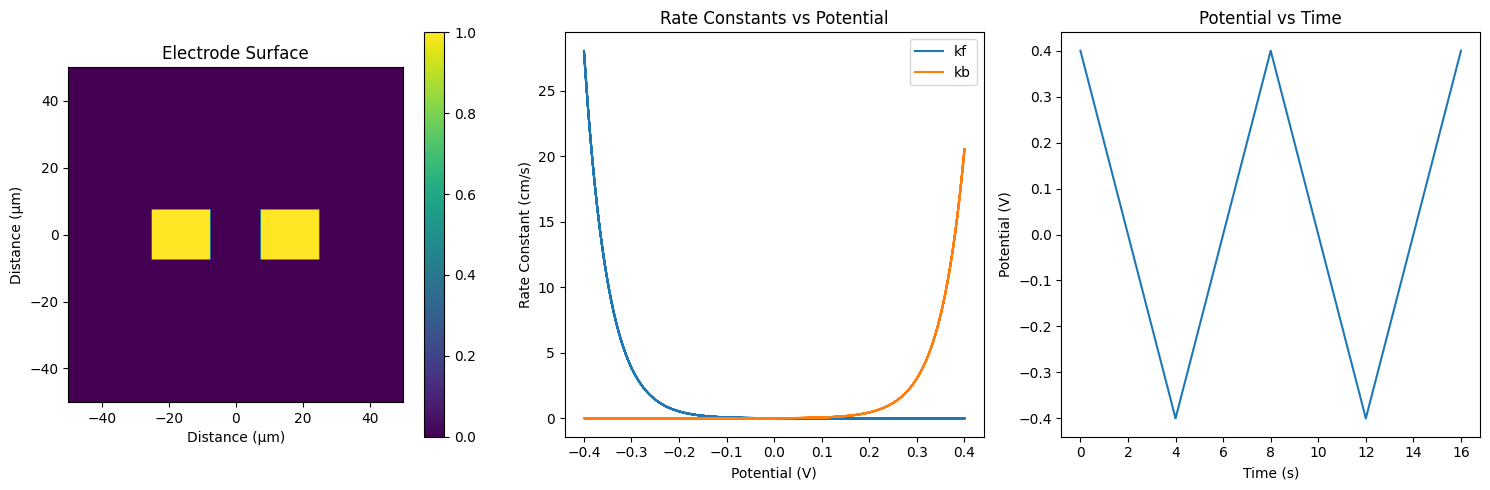

In [17]:
#electrode mask is only the size of the fine grid
electrodeMask     = np.zeros((numBoxs,numBoxs))
m1=int(np.ceil(numBoxs/2-EWidth/2/Dx))
m2=int(np.ceil(numBoxs/2+EWidth/2/Dx))

m1x=int(np.ceil(numBoxs/2-ELength/2/Dx))
m2x=int(np.ceil(numBoxs/2+ELength/2/Dx))
for i in range(m1,m2):
    electrodeMask[i,m1x:m2x]=1

for i in range(m1,m2):
    electrodeMask[m1x:m2x,i]=0
    
del m1,m2,m1x,m2x

# Create figure and subplots with specified size and spacing
fig = plt.figure(figsize=(15, 5))
plt.subplots_adjust(wspace=0.3)  # Add space between subplots

# First subplot - Electrode Mask
ax1 = plt.subplot(131)
im = ax1.imshow(electrodeMask, extent=[gridSize/-2*1e4, gridSize/2*1e4, gridSize/-2*1e4, gridSize/2*1e4])
ax1.set_xlabel('Distance (μm)')
ax1.set_ylabel('Distance (μm)')
ax1.set_title('Electrode Surface')

# Add colorbar
plt.colorbar(im, ax=ax1)

# Second subplot - Rate Constants
ax2 = plt.subplot(132)
ax2.plot(potential, kf, label="kf")
ax2.plot(potential, kb, label="kb")
ax2.set_xlabel("Potential (V)")
ax2.set_ylabel("Rate Constant (cm/s)")
ax2.set_title("Rate Constants vs Potential")
ax2.legend()

# Third subplot - Potential vs Time
ax3 = plt.subplot(133)
ax3.plot(t, potential)
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Potential (V)")
ax3.set_title("Potential vs Time")

# Adjust layout to prevent overlapping
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:

# Define the Laplacian kernel for 3D convolution
laplacian_kernel = torch.tensor(
    [[[[0, 0, 0],
       [0, 1, 0],
       [0, 0, 0]],

      [[0, 1, 0],
       [1, -6, 1],
       [0, 1, 0]],

      [[0, 0, 0],
       [0, 1, 0],
       [0, 0, 0]]]],
    dtype=torch.float32, device=device
).unsqueeze(0)  # Shape: (1, 1, 3, 3, 3)

 
# Function to compute 2nd derivative (diffusion) using convolution
def compute_diffusion(O, gradConst):
    O[1:-1, 1:-1, 1:-1] = O[1:-1, 1:-1, 1:-1] + gradConst * Func.conv3d(O.unsqueeze(0), laplacian_kernel).squeeze(0)
    return O 

# Update the simulate_step function to handle both grids
def simulate_step( electrode_kf, electrode_kb, km, Dx, gradConst, fine_O, fine_R, coarse_O, coarse_R):
    
    fine_O = compute_diffusion(fine_O, gradConst)
    fine_R = compute_diffusion(fine_R, gradConst) - km * fine_R
    
    
    # Calculate reaction rate at surface in the fine grid
    rate = (electrode_kf * fine_O[:, :, 0] - electrode_kb * fine_R[:, :, 0]) *Dt
    J = torch.sum(rate)
    
    # Update surface concentrations in the fine grid
    fine_O[:, :, 0] = fine_O[:, :, 1]- rate
    fine_R[:, :, 0] = fine_R[:, :, 1]+ rate -km * R[:, :, 0]
    
    # Interpolate fine grid to coarse grid
    
    
    # Interpolate fine grid to coarse grid
    coarse_O =compute_diffusion(coarse_O, gradConst)
    coarse_R =compute_diffusion(coarse_R, gradConst) - km * coarse_R

    # Compute the diffusion for O and R in the coarse grid
    coarse_O[:, :, 0] = coarse_O[:, :, 1] 
    coarse_R[:, :, 0] = coarse_R[:, :, 1]  -km * coarse_R[:, :, 0]

    # Update only the edge of the find grid with the corresponding coarse grid values,  the fine grid should be considered the authority with more information
    
    
    return fine_O, fine_R, coarse_O, coarse_R, J

# Initialize O and R concentrations
print(f'Concentration {C}')
fine_O = torch.full((numBoxs, numBoxs, numBoxs), C, dtype=torch.float32, device=device)
fine_R = torch.zeros((numBoxs, numBoxs, numBoxs), dtype=torch.float32, device=device)
coarse_O = torch.full((coarseGrid_numBoxs, coarseGrid_numBoxs, coarseGrid_numBoxs), C, dtype=torch.float32, device=device)
coarse_R = torch.zeros((coarseGrid_numBoxs, coarseGrid_numBoxs, coarseGrid_numBoxs), dtype=torch.float32, device=device)
current = np.zeros((numSteps))
 

In [ ]:

 




# Function to compute a single simulation step
def simulate_step(O, R,electrode_kf,electrode_kb, km, gradConst):
    # Compute the diffusion for O and R
    O = compute_diffusion(O, gradConst)
    R = compute_diffusion(R, gradConst) - km * R
    
    # Apply reactions at the electrode surface
    rate = (electrode_kf * O[:, :, 1]  - electrode_kb * R[:, :, 1] )*Dt
    J = torch.sum(rate)
    O[:, :, 0] = O[:, :, 1]- rate
    R[:, :, 0] = R[:, :, 1]+ rate -km * R[:, :, 0]
    return O, R, J
 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define grid dimensions
nx, ny, nz = numBoxs, numBoxs, numBoxs 

# Initialize O and R concentrations
O = torch.full((nx, ny, int(nz/2)), C, dtype=torch.float32, device=device)  # Initial concentration of O
R = torch.zeros((nx, ny, int(nz/2)), dtype=torch.float32, device=device)   # Initial concentration of R
current = np.zeros( (numSteps))

# Simulate the CV
for step in range(numSteps):
    electrode_kf = torch.tensor( kf[step]* electrodeMask, device=device)  # Forward reaction mask
    electrode_kb =torch.tensor( kb[step]* electrodeMask, device=device)  # Forward reaction mask

    O, R, J = simulate_step(O, R, electrode_kf,electrode_kb, km, gradConst)
    current[step] = (n * F * J*1000).cpu().detach().numpy()

    if step % 100 == 0:
        print('.', end="")
    
    if step % 1000 == 0:
        clear_output(wait=True)
        
        # Plot the CV and slices of O
        fig, ax = plt.subplots(1, 3, figsize=(9, 3))

        # Plot CV
        ax[0].plot(potential , current , label="CV")
        ax[0].set_xlabel("Potential (V)")
        ax[0].set_ylabel("Current (A)")
        ax[0].legend()

        # Plot parallel slice
        parallel_slice = O[:, :, O.shape[-1] // 2].cpu().numpy()
        im1 = ax[1].imshow(parallel_slice, extent=[-gridSize * 1e4 / 2, gridSize * 1e4 / 2] * 2, cmap="viridis")
        ax[1].set_title("Parallel Slice")
        plt.colorbar(im1, ax=ax[1])

        # Plot perpendicular slice
        perpendicular_slice = O[nx // 2, :, :].cpu().numpy()
        im2 = ax[2].imshow(perpendicular_slice.T, extent=[-gridSize * 1e4 / 2, gridSize * 1e4 / 2, -gridSize * 1e4 / 2, gridSize * 1e4 / 2], cmap="viridis")
        ax[2].set_title("Perpendicular Slice")
        plt.colorbar(im2, ax=ax[2])

        plt.tight_layout()
        plt.show()      


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.85 GiB. GPU 